# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?


In [42]:
#!pip install pandas-profiling


# Import Data

In [43]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

#from ydata_profiling import ProfileReport

#data = pd.read_csv('data_BCN.csv')

from google.colab import drive
drive.mount('/content/drive')

# Set current directory if running from Google Collab
path= '/content/drive/My Drive/IDD_HW/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PreProcessing

In [44]:
data = pd.read_csv(path + 'data_BCN.csv')
data.head(10)


,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN
5,2021-02-01 05:00:00,0.0,BCN
6,2021-02-01 06:00:00,2.0,BCN
7,2021-02-01 07:00:00,3.0,BCN
8,2021-02-01 08:00:00,9.0,BCN
9,2021-02-01 09:00:00,33.0,BCN


city: All data points are from Barcelona (BCN). Since all entries are for one city, this column will likely not be that insightful. Orders will also need to be converted to integers

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8766 non-null   object 
 1   orders  8766 non-null   float64
 2   city    8766 non-null   object 
dtypes: float64(1), object(2)
memory usage: 205.6+ KB


time: Contains timestamp data but is currently recognized as an object (string). This needs to be converted to a datetime type.

In [46]:
data.describe()

,orders
count,8766.000000
mean,73.145175
std,111.038384
min,0.000000
25%,0.000000
50%,30.000000
75%,97.000000
max,939.000000


Counts of orders per hour, which range from 0 to 939. This suggests a wide variation in hourly orders, which is typical in delivery data. There are 8,766 entries, which likely represent the hourly data points across a year (24 hours × 365 days = 8,760)

In [47]:
data.isnull().sum()

time      0
orders    0
city      0
dtype: int64

In [48]:
data['time'] = pd.to_datetime(data['time'])
data['orders'] = data['orders'].astype(int)
data.head(10)

,time,orders,city
0,2021-02-01 00:00:00,0,BCN
1,2021-02-01 01:00:00,0,BCN
2,2021-02-01 02:00:00,0,BCN
3,2021-02-01 03:00:00,0,BCN
4,2021-02-01 04:00:00,0,BCN
5,2021-02-01 05:00:00,0,BCN
6,2021-02-01 06:00:00,2,BCN
7,2021-02-01 07:00:00,3,BCN
8,2021-02-01 08:00:00,9,BCN
9,2021-02-01 09:00:00,33,BCN


## EDA

In [49]:
px.line(data, x='time', y='orders')

General Trend:

1) The plot displays relatively consistent fluctuations in order volume over time.
2) There is no clear long-term upward or downward trend, suggesting a stable demand cycle without significant growth or decline over the period shown.
3) Peaks and troughs, corresponding to weekly cycles.
4) High spikes could be influenced by events or promotions.
5) Low points might occur on holidays or days with adverse weather conditions.


In [50]:
# find zero values

zero_values = data[data['orders'] == 0]
print(zero_values.shape[0] / data.shape[0] * 100)

31.918777093315082


In [52]:
# get season for each row
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


data['day_of_week'] = data['time'].dt.day_name()
data['month'] = data['time'].dt.month
data['season'] = data['month'].apply(get_season)
data['year'] = data['time'].dt.year

data.head(10)


,time,orders,city,day_of_week,month,season,year
0,2021-02-01 00:00:00,0,BCN,Monday,2,Winter,2021
1,2021-02-01 01:00:00,0,BCN,Monday,2,Winter,2021
2,2021-02-01 02:00:00,0,BCN,Monday,2,Winter,2021
3,2021-02-01 03:00:00,0,BCN,Monday,2,Winter,2021
4,2021-02-01 04:00:00,0,BCN,Monday,2,Winter,2021
5,2021-02-01 05:00:00,0,BCN,Monday,2,Winter,2021
6,2021-02-01 06:00:00,2,BCN,Monday,2,Winter,2021
7,2021-02-01 07:00:00,3,BCN,Monday,2,Winter,2021
8,2021-02-01 08:00:00,9,BCN,Monday,2,Winter,2021
9,2021-02-01 09:00:00,33,BCN,Monday,2,Winter,2021


### Top 5 Orders

In [53]:
# Find the dates with the top 3 highest orders
top_orders = data.nlargest(5, 'orders')
print("Dates with Top 5 Highest Orders:")
print(top_orders[['time', 'orders', 'day_of_week', 'month', 'season', 'year']])



Dates with Top 5 Highest Orders:
                    time  orders day_of_week  month  season  year
5649 2021-09-24 21:00:00     939      Friday      9  Autumn  2021
4137 2021-07-23 21:00:00     873      Friday      7  Summer  2021
1287 2021-03-26 21:00:00     846      Friday      3  Spring  2021
7851 2021-12-25 21:00:00     778    Saturday     12  Winter  2021
8163 2022-01-07 21:00:00     778      Friday      1  Winter  2022


1) Time Consistency: All the top order instances occurred at the same hour, 21:00 (9 PM). This suggests that there is a peak demand time in the evening, likely due to dinner orders.

2) Day Consistency: Four out of the five dates are Fridays, with one being a Saturday. This implies a trend where higher order volumes are typical towards the end of the week, possibly due to people engaging in social activities at the end of the workweek.


3) September 24, 2021 (Friday): This date coincides with La Mercè, which would explain a significant increase in orders due to celebrations throughout the city.

4) July 23, 2021 (Friday): This date does not correspond directly with any specific large event, but being a Friday in the summer, it could be related to typical seasonal vacations.

5) March 26, 2021 (Friday): This date falls on a Friday in spring, and does not correlate with a major public holiday or event.

6) December 25, 2021 (Saturday): This is Christmas Day. Despite many restaurants being closed, those that remain open might see a surge in orders from people choosing to order in rather than cook at home.

7) January 7, 2022 (Friday): This is shortly after New Year's Day and during the time of the Three Kings Day celebrations (January 6th), which is a significant holiday in Spain, which could explain the high order volume.

In [54]:
# plot order count by day of week in a bar chart plotly
grouped = data.groupby('day_of_week')['orders'].sum().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='day_of_week', y='orders', title='Order count by day of week')
fig.show()



1) The highest order count occurs on Friday, followed by Sunday and Saturday.
2) The weekdays, from Monday to Thursday, show a relatively similar number of orders, with slight variations.

In [55]:
# plot order count by season in a bar chart plotly
grouped = data.groupby('season')['orders'].sum().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='season', y='orders', title='Order count by season')
fig.show()



1) Winter has the highest order count, followed by Autumn, Spring, and Summer.
2) This could indicate that more orders are placed in colder months

In [56]:
# Map the month numbers to month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
data['month_name'] = data['month'].map(month_names)

# Group by the new 'month_name' column
grouped = data.groupby('month_name')['orders'].sum().reset_index()

# Plotly might not automatically sort the months correctly, so we'll sort them manually
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
grouped['month_name'] = pd.Categorical(grouped['month_name'], categories=ordered_months, ordered=True)
grouped = grouped.sort_values('month_name')

# Plot order count by month with month names
fig = px.bar(grouped, x='month_name', y='orders', title='Order count by month')
fig.show()



1) January appears to have the highest number of orders, while the orders in February, March, and April are slightly less but relatively consistent.
2) There's a noticeable drop in orders in August (month 8), which could be due to various factors such as holidays or seasonal changes in customer behaviour.

In [57]:
data.head()

,time,orders,city,day_of_week,month,season,year,month_name
0,2021-02-01 00:00:00,0,BCN,Monday,2,Winter,2021,February
1,2021-02-01 01:00:00,0,BCN,Monday,2,Winter,2021,February
2,2021-02-01 02:00:00,0,BCN,Monday,2,Winter,2021,February
3,2021-02-01 03:00:00,0,BCN,Monday,2,Winter,2021,February
4,2021-02-01 04:00:00,0,BCN,Monday,2,Winter,2021,February


In [58]:
# plot day of the week grouped by season in a grouped bar chart plotly

grouped = data.groupby(['day_of_week', 'season'])['orders'].sum().reset_index()

fig = px.bar(grouped, x='season', y='orders', color='day_of_week', title='Order count by day of week grouped by season', barmode='group')
fig.show()



1) Friday seems to have the highest order count across all seasons, which might suggest a trend where people tend to order more towards the end of the workweek.
2) The lowest order counts seem to be on Wednesday, though the patterns vary with the season.
3) The order counts are highest in Winter and lowest in Summer.

In [59]:
data.head()

,time,orders,city,day_of_week,month,season,year,month_name
0,2021-02-01 00:00:00,0,BCN,Monday,2,Winter,2021,February
1,2021-02-01 01:00:00,0,BCN,Monday,2,Winter,2021,February
2,2021-02-01 02:00:00,0,BCN,Monday,2,Winter,2021,February
3,2021-02-01 03:00:00,0,BCN,Monday,2,Winter,2021,February
4,2021-02-01 04:00:00,0,BCN,Monday,2,Winter,2021,February


In [60]:
# Copy relevant columns to a new DataFrame
df_hm = data[['season', 'day_of_week', 'orders']].copy()

# Convert categorical variables to numeric codes
df_hm['season'] = df_hm['season'].astype('category').cat.codes
df_hm['day_of_week'] = df_hm['day_of_week'].astype('category').cat.codes

# Pivot the data
pivot_data = df_hm.pivot_table(index='season', columns='day_of_week', values='orders', aggfunc='sum')

# Create heatmap
fig = px.imshow(pivot_data,
                labels=dict(x="Day of Week", y="Season", color="Order Magnitude"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                y=['Fall', 'Spring', 'Summer', 'Winter'],
                title='Order Magnitude Heatmap by Day of Week and Season')
fig.show()



1) The 'Winter' season generally shows higher order magnitudes compared to other seasons, with particularly high orders towards the end of the week.
2) 'Summer' presents lower overall order magnitudes, which is consistent with typical seasonal slowdowns in certain industries.
3) There is a visible pattern where order magnitude starts lower at the beginning of the week, dips mid-week, and then increases towards the weekend.
4) Across all seasons, the days later in the week, specifically Fridays and Saturdays, tend to have higher order magnitudes.
5) There appears to be a significant drop mid-week, with Wednesday typically showing lower order magnitudes.


### Zero order analysis

In [61]:
# get df with only zeros

zero_values = data[data['orders'] == 0]

zero_values.head()



,time,orders,city,day_of_week,month,season,year,month_name
0,2021-02-01 00:00:00,0,BCN,Monday,2,Winter,2021,February
1,2021-02-01 01:00:00,0,BCN,Monday,2,Winter,2021,February
2,2021-02-01 02:00:00,0,BCN,Monday,2,Winter,2021,February
3,2021-02-01 03:00:00,0,BCN,Monday,2,Winter,2021,February
4,2021-02-01 04:00:00,0,BCN,Monday,2,Winter,2021,February


In [62]:
# get season for each row
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'


zero_values['day_of_week'] = zero_values['time'].dt.day_name()
zero_values['month'] = zero_values['time'].dt.month
zero_values['season'] = zero_values['month'].apply(get_season)
zero_values['year'] = zero_values['time'].dt.year



<ipython-input-62-f934cfd6674e>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-f934cfd6674e>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-f934cfd6674e>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-62-f934

In [63]:
grouped = zero_values.groupby('day_of_week')['city'].count().reset_index()

# sort data
grouped = grouped.sort_values('city', ascending=False)

fig = px.bar(grouped, x='day_of_week', y='city', title='Count of Zero Orders by day of week')
fig.show()



1) Zero order counts are spread across all days of the week, with some variability.
2) Tuesday has the most instances of zero orders.
3) Friday follows as the second-highest.
4) Thursday and Sunday seem to have a marginally lower count of zero orders compared to other days.

In [64]:
data.head()

,time,orders,city,day_of_week,month,season,year,month_name
0,2021-02-01 00:00:00,0,BCN,Monday,2,Winter,2021,February
1,2021-02-01 01:00:00,0,BCN,Monday,2,Winter,2021,February
2,2021-02-01 02:00:00,0,BCN,Monday,2,Winter,2021,February
3,2021-02-01 03:00:00,0,BCN,Monday,2,Winter,2021,February
4,2021-02-01 04:00:00,0,BCN,Monday,2,Winter,2021,February


In [65]:
# plot order count by season in a bar chart plotly
grouped = zero_values.groupby('season')['orders'].count().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='season', y='orders', title='Order count by season')
fig.show()



1) Summer has the highest number of orders, followed closely by Spring.
2) Autumn and Winter have a lower count, with Winter having the least.
3) Distribution suggests a seasonal impact on orders. This could be due to several factors, including weather conditions, holiday periods, or consumer behavior that changes with the seasons.


In [66]:
# Map the numeric months to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
               5: 'May', 6: 'June', 7: 'July', 8: 'August',
               9: 'September', 10: 'October', 11: 'November', 12: 'December'}
zero_values['month_name'] = zero_values['month'].map(month_names)

# Group by the new 'month_name' column
grouped = zero_values.groupby('month_name')['orders'].count().reset_index()

# Ensure that the months are ordered correctly
grouped['month_name'] = pd.Categorical(grouped['month_name'], categories=month_names.values(), ordered=True)
grouped = grouped.sort_values('month_name')

# Plot order count by month with month names
fig = px.line(grouped, x='month_name', y='orders', title='Zero Order Count by Month')
fig.show()



<ipython-input-66-e23cb9942e60>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1) The lowest point occurs in Februay, the month with the fewest occurrences of no orders and the highest peak is in August.
2) Increased variability during the summer months (June to August), with a sharp increase to the highest point in August followed by a sharp decrease in September.


In [67]:
"""
# plot order count by month in a bar chart plotly
grouped = zero_values.groupby('month')['orders'].count().reset_index()

fig = px.line(grouped, x='month', y='orders', title='Zero Order Count by month')
fig.show()
"""

"\n# plot order count by month in a bar chart plotly\ngrouped = zero_values.groupby('month')['orders'].count().reset_index()\n\nfig = px.line(grouped, x='month', y='orders', title='Zero Order Count by month')\nfig.show()\n"

In [68]:
# plot day of the week grouped by season in a grouped bar chart plotly

grouped = zero_values.groupby(['day_of_week', 'season'])['orders'].count().reset_index()

fig = px.bar(grouped, x='season', y='orders', color='day_of_week', barmode='group' , title='Zero order count by day of week grouped by season')
fig.show()



1) The distribution of zero orders is relatively uniform across different seasons, suggesting that the lack of orders is not strongly influenced by seasonal changes.
2) here is no single day that consistently has the highest or lowest number of zero orders across all seasons, indicating that zero orders are not particularly tied to specific days of the week.
3) While the distributions are similar, there are slight variations in zero order counts between days and seasons, which could be due to natural business cycles or external factors not displayed on the chart.


In [69]:
# Copy relevant columns to a new DataFrame to avoid modifying the original data
df_hm2 = data[['season', 'day_of_week', 'orders']].copy()

# Convert categorical variables to numeric codes
df_hm2['season'] = df_hm2['season'].astype('category').cat.codes
df_hm2['day_of_week'] = df_hm2['day_of_week'].astype('category').cat.codes

# Pivot the data to count zero orders by season and day of the week
pivot_data = df_hm2.pivot_table(index='season', columns='day_of_week', values='orders', aggfunc=lambda x: (x==0).sum())

# Create heatmap
fig = px.imshow(pivot_data,
                labels=dict(x="Day of Week", y="Season", color="Order Magnitude"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                y=['Fall', 'Spring', 'Summer', 'Winter'],
                title='Zero Order Days Heatmap by Day of Week and Season')
fig.show()

# Save the pivot table to df_hm2
df_hm2 = pivot_data



1) There is a noticeable hotspot on Saturday during the Summer, where the color is visibly lighter, indicating this day has a higher frequency of zero orders compared to other days and seasons.
2) Otherwise the heatmap suggests a relatively even distribution of zero-order days across the days of the week and seasons

## Hourly, Shift and Outlier EDA
- mealtime

- shift

- outliers

## Outlier Treatment, Scaling, Train Test Split with Data Leakage test
- outliers

- scaling

- train test split

- data leakage test

## ACF & PACF Analysis for Time Series
- seasonal

- trend

- stationarity

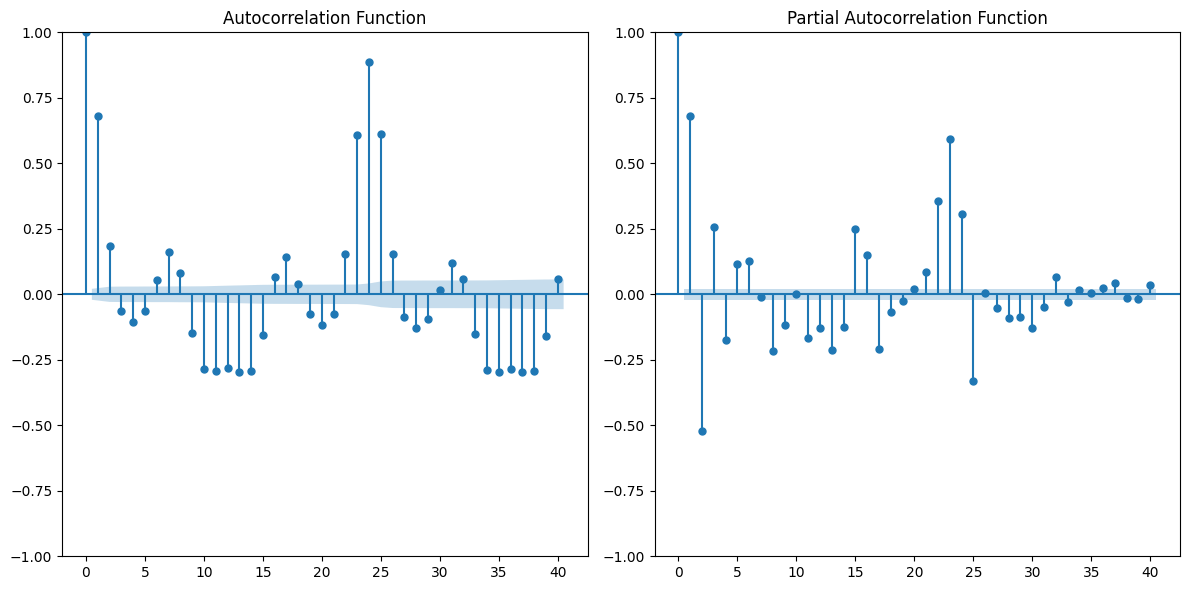

In [70]:
# First, we'll perform ACF and PACF analysis:

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF analysis
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(data['orders'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(data['orders'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


***ACF (Autocorrelation Function) Interpretation:***
Lag 1: There is a high positive autocorrelation at lag 1. This indicates that the current value of orders is positively correlated with the previous hour's orders.
Lag 24: There is another significant spike around lag 24, suggesting a strong daily seasonality in the data. This means the order patterns repeat approximately every 24 hours.

***PACF (Partial Autocorrelation Function) Interpretation:***
Lag 1: There is a significant positive spike at lag 1, indicating that the most recent hour's orders strongly influence the current hour's orders.
Lag 24: Another significant spike at lag 24, which indicates that after accounting for the intermediate lags.
Further lags: After lag 24, the partial autocorrelation values drop off more quickly compared to the ACF.

- Trend: There is no clear long-term upward or downward trend in the data, indicating stable demand over the period.
- Seasonality: The daily seasonality is evident from the significant spikes at multiples of 24 lags in both ACF and PACF plots. This suggests that the number of orders tends to follow a daily cycle.
- Stationarity: The slow decay in ACF and significant spikes in PACF at regular intervals suggest non-stationarity, likely due to the seasonality in the data. Differencing or seasonal decomposition might be necessary to achieve stationarity.

For our further analysis we will perform seasonal decomposition, trend, and stationarity analysis.

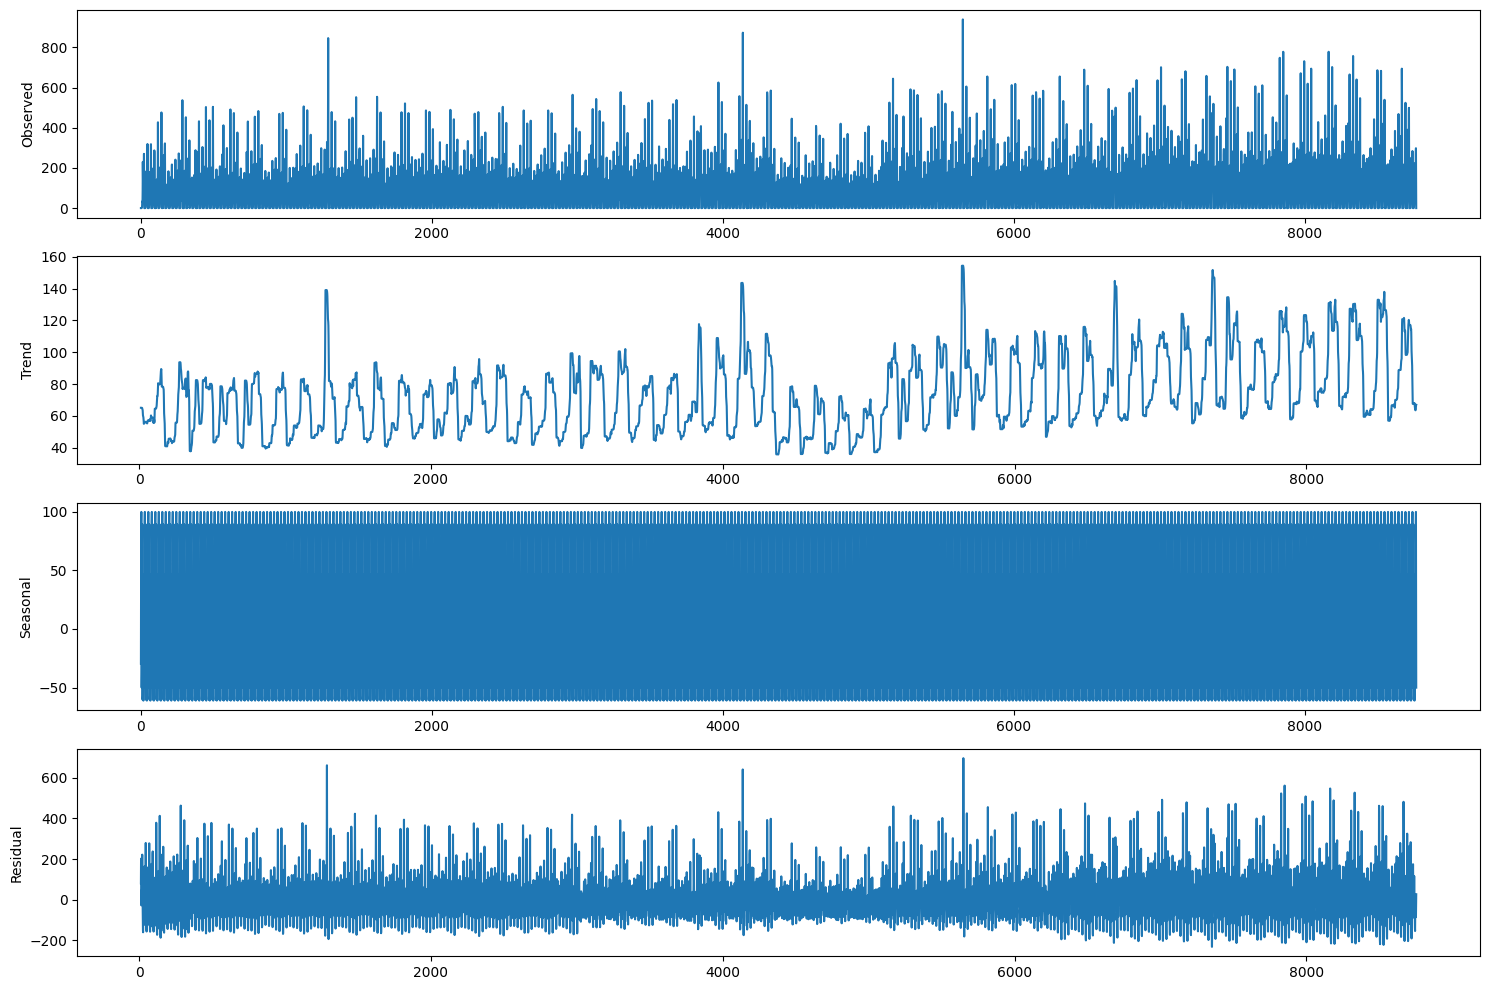

In [71]:
# Seasonal Decomposition
# Next, we'll decompose the time series to extract trend, seasonality, and residuals:

from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomposition = seasonal_decompose(data['orders'], model='additive', period=24)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()


1. **Observed**: The observed data displays variations in the number of orders over time, with noticeable fluctuations that suggest potential seasonal patterns and some peaks at certain intervals.
2. **Trend**: The trend line shows a general pattern in the number of orders. It appears that there are periods of higher and lower order volumes, indicating some cyclical behavior over longer periods. For instance, there are noticeable peaks that repeat approximately every few months.
3. **Seasonal**: The seasonal component indicates a strong daily seasonality, as shown by the repeating pattern.
4. **Residual**: The residuals appear to fluctuate around zero, with some noticeable spikes. These spikes could indicate outliers or unexpected variations in the data that are not explained by the trend or seasonality.

In [72]:
# Stationarity Test
# To check the stationarity of the time series, we'll use the Augmented Dickey-Fuller test:

from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
adf_result = adfuller(data['orders'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')


ADF Statistic: -10.400804672651875
p-value: 1.9117196342292884e-18
Critical Value 1%: -3.4310993669444065
Critical Value 5%: -2.86187117030305
Critical Value 10%: -2.566946276984866


## Weekly and Monthly Aggregation

In [73]:
# Weekly and Monthly Aggregation
data.set_index('time', inplace=True)

# Resample and aggregate
weekly_df = data.resample('W').agg({
    'orders': 'sum'
})
monthly_df = data.resample('M').agg({
    'orders': 'sum'
})

# Feature Engineering: Calculate EMA for Weekly and Monthly Orders
span = 4

# Calculate EMA for Weekly Orders
weekly_df['EMA_Weekly_Orders'] = weekly_df['orders'].ewm(span=span, adjust=False).mean()

# Calculate EMA for Monthly Orders
monthly_df['EMA_Monthly_Orders'] = monthly_df['orders'].ewm(span=span, adjust=False).mean()

# Print results to verify
print("Weekly EMA Orders:")
print(weekly_df.head())

print("\nMonthly EMA Orders:")
print(monthly_df.head())


Weekly EMA Orders:
            orders  EMA_Weekly_Orders
time                                 
2021-02-07   11042          11042.000
2021-02-14   10307          10748.000
2021-02-21   11199          10928.400
2021-02-28   10854          10898.640
2021-03-07   11022          10947.984

Monthly EMA Orders:
            orders  EMA_Monthly_Orders
time                                  
2021-02-28   43402            43402.00
2021-03-31   46257            44544.00
2021-04-30   45774            45036.00
2021-05-31   47955            46203.60
2021-06-30   47739            46817.76


## Stationarity Check, Differencing, and Plotting for Weekly Data

In [74]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity for a list of columns
def check_stationarity(df, columns):
    non_stationary_series = []
    for column in columns:
        result = adfuller(df[column].dropna())
        p_value = result[1]  # p-value is at index 1 of the result
        if p_value >= 0.05:
            non_stationary_series.append(column)
    return non_stationary_series

# Check stationarity for weekly data columns
weekly_columns = ['EMA_Weekly_Orders']
non_stationary_results = check_stationarity(weekly_df, weekly_columns)

# Output the initial stationarity results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")

Non-stationary series:
EMA_Weekly_Orders


In [75]:
# Function to apply differencing to make the series stationary
def apply_diff_and_update(df, column_name):
    diff_column_name = column_name + '_diff'
    df[diff_column_name] = df[column_name].diff()
    df.dropna(subset=[diff_column_name], inplace=True)
    return diff_column_name

# Apply differencing to non-stationary series
diff_columns = []
for column in non_stationary_results:
    diff_column = apply_diff_and_update(weekly_df, column)
    diff_columns.append(diff_column)

In [76]:
# Check stationarity again after differencing
non_stationary_results_after_diff = check_stationarity(weekly_df, diff_columns)

# Output the results after differencing
if non_stationary_results_after_diff:
    print("Non-stationary series after first differencing:")
    for series in non_stationary_results_after_diff:
        print(series)
else:
    print("All series are stationary after first differencing.")

Non-stationary series after first differencing:
EMA_Weekly_Orders_diff


In [77]:
# If there are still non-stationary series after first differencing, apply second differencing
if non_stationary_results_after_diff:
    second_diff_columns = []
    for column in non_stationary_results_after_diff:
        second_diff_column = apply_diff_and_update(weekly_df, column)
        second_diff_columns.append(second_diff_column)

    # Check stationarity again after second differencing
    non_stationary_results_after_second_diff = check_stationarity(weekly_df, second_diff_columns)

    # Output the results after second differencing
    if non_stationary_results_after_second_diff:
        print("Non-stationary series after second differencing:")
        for series in non_stationary_results_after_second_diff:
            print(series)
    else:
        print("All series are stationary after second differencing.")

All series are stationary after second differencing.


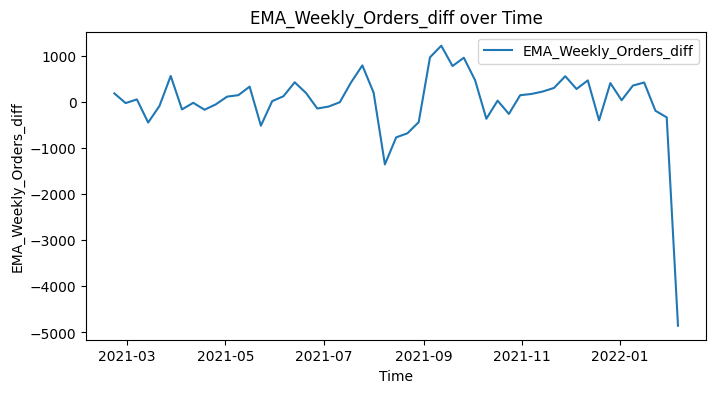

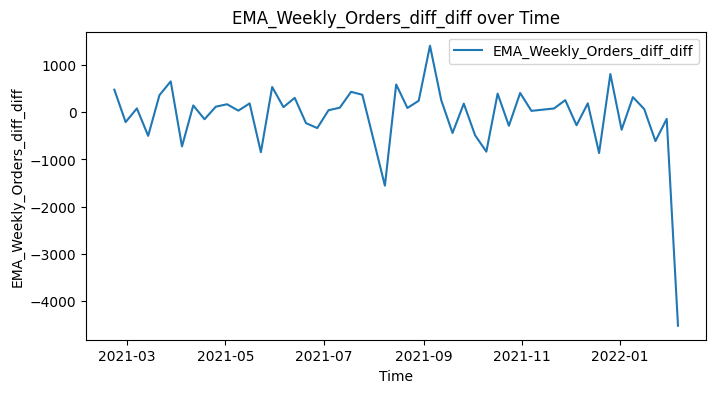

In [78]:
# Plot the differenced series
for column in diff_columns + second_diff_columns:
    plt.figure(figsize=(8, 4))
    plt.plot(weekly_df.index, weekly_df[column], label=column)
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title(f'{column} over Time')
    plt.legend()
    plt.show()


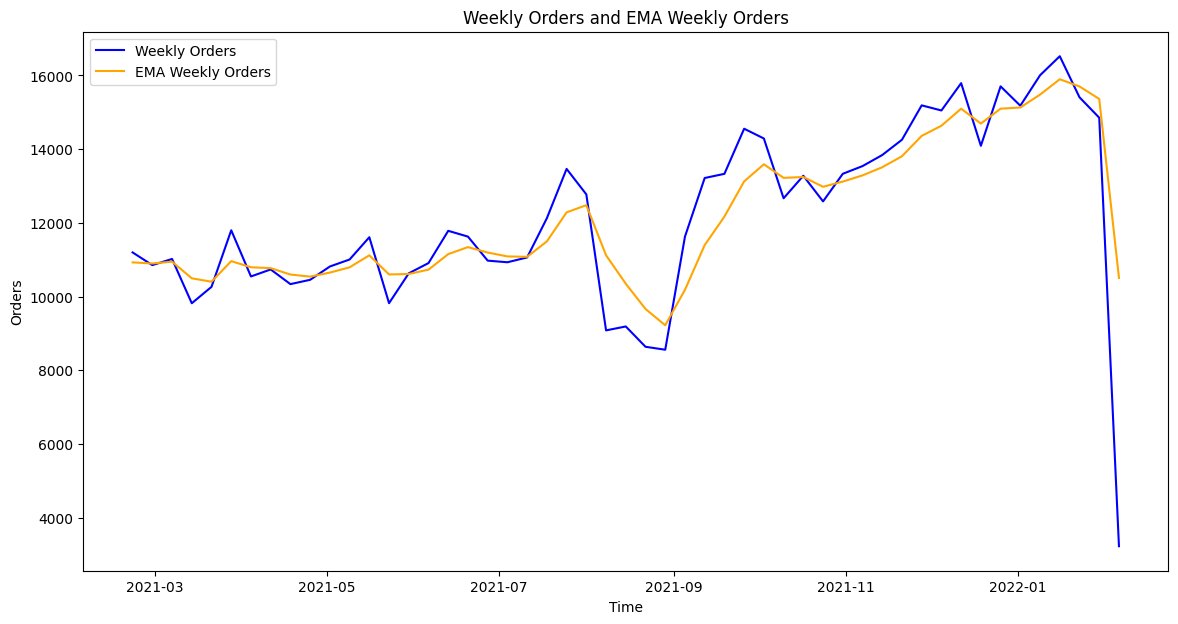

In [81]:
# Plot Weekly Orders and EMA Weekly Orders
plt.figure(figsize=(14, 7))
plt.plot(weekly_df.index, weekly_df['orders'], label='Weekly Orders', color='blue')
plt.plot(weekly_df.index, weekly_df['EMA_Weekly_Orders'], label='EMA Weekly Orders', color='orange')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.title('Weekly Orders and EMA Weekly Orders')
plt.legend()
plt.show()


## Stationarity Check, Differencing, and Plotting for Monthly Data

Non-stationary series:
EMA_Monthly_Orders
All series are stationary after differencing.


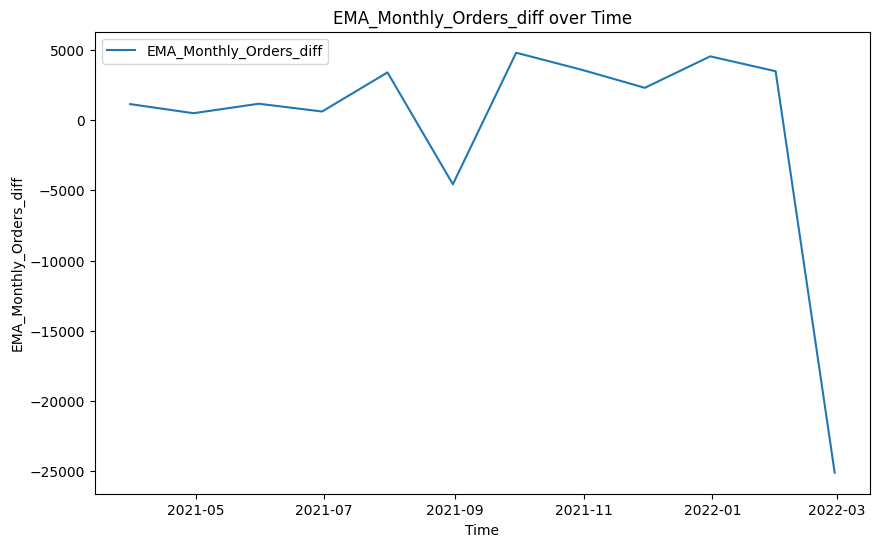

In [79]:
# Check stationarity for monthly data columns
monthly_columns = ['EMA_Monthly_Orders']
non_stationary_results = check_stationarity(monthly_df, monthly_columns)

# Output the initial stationarity results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")

# Apply differencing to non-stationary series
for column in non_stationary_results:
    apply_diff_and_update(monthly_df, column)

# Check stationarity again after differencing
diff_columns_to_check = [col + '_diff' for col in non_stationary_results]
non_stationary_results_after_diff = check_stationarity(monthly_df, diff_columns_to_check)

# Output the results after differencing
if non_stationary_results_after_diff:
    print("Non-stationary series after differencing:")
    for series in non_stationary_results_after_diff:
        print(series)
else:
    print("All series are stationary after differencing.")

# Plot the differenced series
for column in diff_columns_to_check:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_df.index, monthly_df[column], label=column)
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.title(f'{column} over Time')
    plt.legend()
    plt.show()


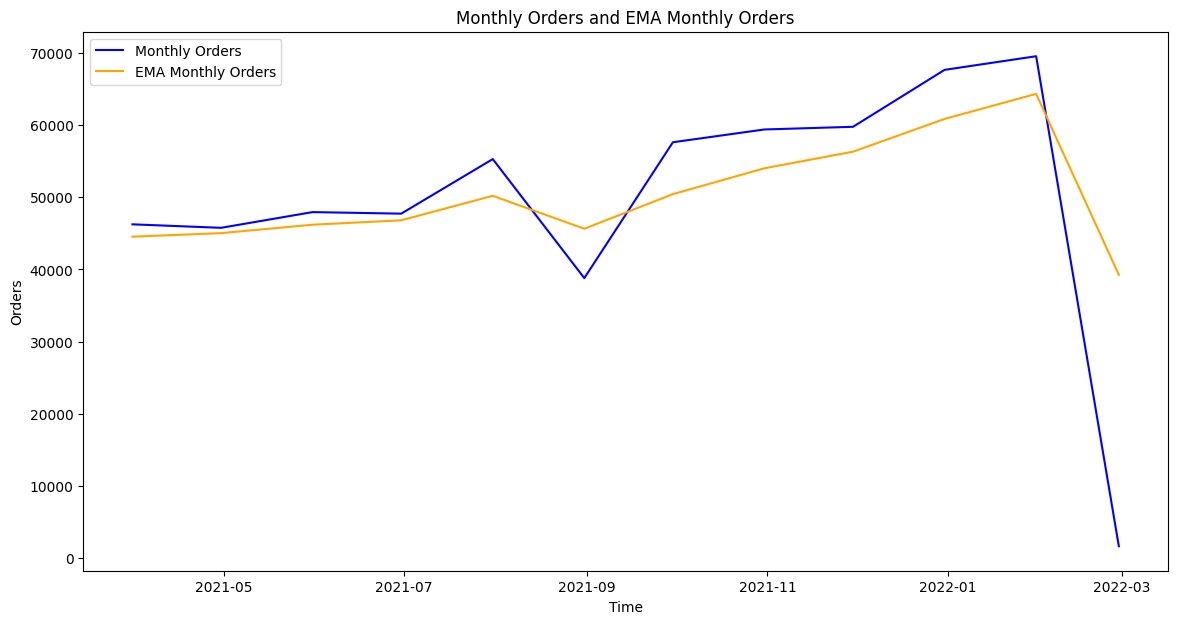

In [80]:
# Plot Monthly Orders and EMA Monthly Orders
plt.figure(figsize=(14, 7))
plt.plot(monthly_df.index, monthly_df['orders'], label='Monthly Orders', color='blue')
plt.plot(monthly_df.index, monthly_df['EMA_Monthly_Orders'], label='EMA Monthly Orders', color='orange')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.title('Monthly Orders and EMA Monthly Orders')
plt.legend()
plt.show()



## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?


- ARIMA

        done
        
- SARIMA

        done

- Random Forest

        done

- LSTM

    
- Prophet

    
- XGBoost
    
    
- LightGBM

### 1. Autoregressive Integrated Moving Average (ARIMA) & Seasonal ARIMA (SARIMA)

In [39]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming data is already prepared and 'orders' is your target variable

# Split data into train and test
train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

# ARIMA Model
arima_model = ARIMA(train['orders'], order=(1,1,1))
arima_fitted = arima_model.fit()
arima_forecast = arima_fitted.forecast(steps=len(test))

# SARIMA Model
sarima_model = SARIMAX(train['orders'], order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_fitted = sarima_model.fit()
sarima_forecast = sarima_fitted.forecast(steps=len(test))

# Calculate and print errors
for forecast, model_name in [(arima_forecast, 'ARIMA'), (sarima_forecast, 'SARIMA')]:
    mse = mean_squared_error(test['orders'], forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test['orders'], forecast)
    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the 

ARIMA - MSE: 481674.91013727203, RMSE: 694.028032673949, MAE: 680.82645165399
SARIMA - MSE: 2892.47796066034, RMSE: 53.78176234245527, MAE: 29.791960697796462


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



### 3) Random Forest

In [40]:
data.head()

,orders,city,day_of_week,month,season,year,month_name
time,,,,,,,
2021-02-01 00:00:00,0,BCN,Monday,2,Winter,2021,February
2021-02-01 01:00:00,0,BCN,Monday,2,Winter,2021,February
2021-02-01 02:00:00,0,BCN,Monday,2,Winter,2021,February
2021-02-01 03:00:00,0,BCN,Monday,2,Winter,2021,February
2021-02-01 04:00:00,0,BCN,Monday,2,Winter,2021,February


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Assuming 'data' is your DataFrame and has been loaded and preprocessed correctly

# Convert 'time' into more granular features and remove unwanted columns
data['hour'] = data['time'].dt.hour
data.drop(['time', 'city', 'month_name'], axis=1, inplace=True)  # Drop columns if they are not needed

# Encoding categorical variables
categorical_features = ['day_of_week', 'season']
onehot_encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

X = data.drop('orders', axis=1)
y = data['orders']

X_encoded = onehot_encoder.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=42)

# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

# Output predictions
print("Predictions:", predictions)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print(f'Random Forest - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


KeyError: 'time'

Random Forest has best overall performance, this suggests that the time series has strong non-linear components